In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, roc_auc_score,
    roc_curve, f1_score
)
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import make_pipeline
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import label_binarize
from collections import Counter
import joblib

In [10]:
class SafeSMOTENC(SMOTENC):
    def fit_resample(self, X, y):
        class_counts = Counter(y)
        min_class_count = min(class_counts.values())
        safe_k = max(1, min(5, min_class_count - 1))

        # Directly assign to k_neighbors if it's an int
        self.k_neighbors = safe_k
        return super().fit_resample(X, y)

In [11]:
# Load and inspect data
data = pd.read_csv('Dataset_of_Diabetes.csv')
data['CLASS'] = data['CLASS'].str.strip()

# Dataset head
print("Dataset Preview:")
print(data.head())

# Missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Statistical summary
print("\nStatistical Summary:")
print(data.describe())

Dataset Preview:
    ID  No_Pation Gender  AGE  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL  \
0  502      17975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
1  735      34221      M   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6   
2  420      47975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
3  680      87656      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
4  504      34223      M   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4   

    BMI CLASS  
0  24.0     N  
1  23.0     N  
2  24.0     N  
3  24.0     N  
4  21.0     N  

Missing Values:
ID           0
No_Pation    0
Gender       0
AGE          0
Urea         0
Cr           0
HbA1c        0
Chol         0
TG           0
HDL          0
LDL          0
VLDL         0
BMI          0
CLASS        0
dtype: int64

Statistical Summary:
                ID     No_Pation          AGE         Urea           Cr  \
count  1000.000000  1.000000e+03  1000.000000  1000.000000  1000.000000   
mean    340.

In [12]:
# Manual class mapping
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['CLASS'] = label_encoder.fit_transform(data['CLASS'])
class_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
class_names = list(class_mapping.values())

# Split data
X = data.drop(columns=['ID', 'No_Pation', 'CLASS'])
y = data['CLASS']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Class Distribution
def print_class_distribution(y, title):
    counts = pd.Series(y).value_counts().sort_index()
    print(f"\n{title}:")
    print(counts)
    print("Percentages:")
    print(round(counts / len(y) * 100, 2))

print_class_distribution(y_train, "Training Distribution")


Training Distribution:
CLASS
0     82
1     43
2    675
Name: count, dtype: int64
Percentages:
CLASS
0    10.25
1     5.38
2    84.38
Name: count, dtype: float64


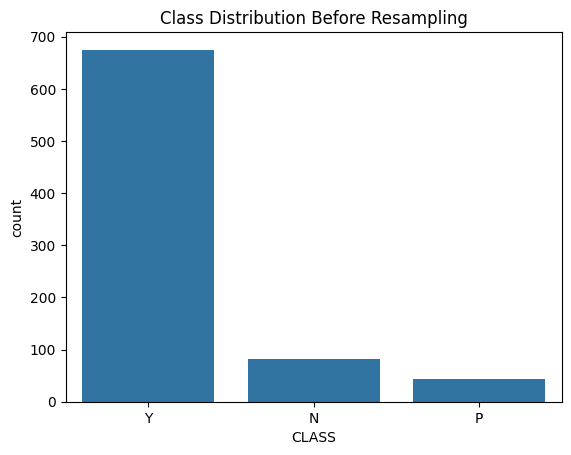

In [13]:
# Plot class distribution before resampling
sns.countplot(x=y_train.map(class_mapping))
plt.title("Class Distribution Before Resampling")
plt.show()


Feature Importance (Mutual Info):
HbA1c     0.374605
BMI       0.275678
AGE       0.236753
VLDL      0.067581
Cr        0.064863
Chol      0.055630
TG        0.041637
Urea      0.037726
HDL       0.030958
LDL       0.016144
Gender    0.005737
dtype: float64


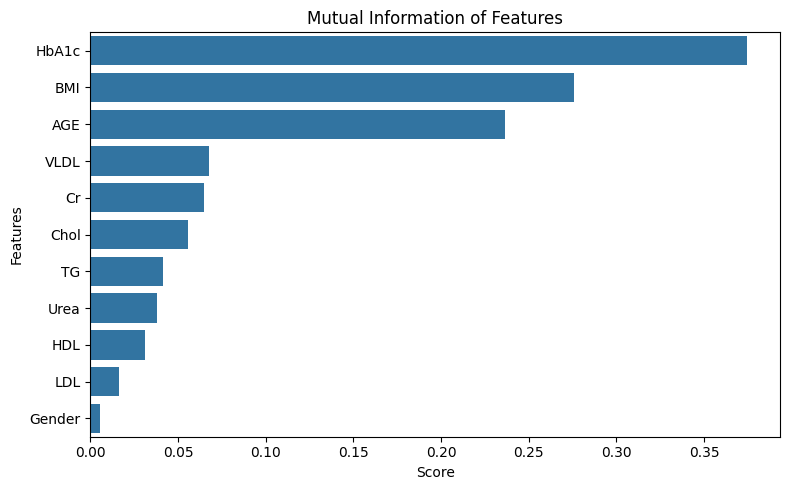

In [14]:
# Feature importance (mutual information)
mi = mutual_info_classif(X_train, y_train)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("\nFeature Importance (Mutual Info):")
print(mi_series)

# Plot Mutual Information
plt.figure(figsize=(8, 5))
sns.barplot(x=mi_series.values, y=mi_series.index)
plt.title("Mutual Information of Features")
plt.xlabel("Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# Categorical feature index
cat_index = X.columns.get_loc('Gender')

In [15]:
# Models and hyperparameters
models = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, class_weight='balanced'),
        "params": {
            'randomforestclassifier__n_estimators': [100, 200],
            'randomforestclassifier__max_depth': [5, 10, None],
            'randomforestclassifier__min_samples_split': [2, 5]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        "params": {
            'logisticregression__C': [0.1, 1, 10],
            'logisticregression__penalty': ['l2']
        }
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "params": {
            'kneighborsclassifier__n_neighbors': [3, 5, 7],
            'kneighborsclassifier__weights': ['uniform', 'distance']
        }
    },
    "Support Vector Machine": {
        "model": SVC(random_state=42, probability=True, class_weight='balanced'),
        "params": {
            'svc__C': [0.1, 1, 10],
            'svc__kernel': ['linear', 'rbf']
        }
    }
}


=== Training Random Forest ===
Random Forest - After Resampling Class Counts:
CLASS
0    675
1    675
2    675
Name: count, dtype: int64
Random Forest Feature Importances:
HbA1c     0.449354
BMI       0.247126
AGE       0.145092
Gender    0.031690
TG        0.031235
Chol      0.028581
VLDL      0.024298
LDL       0.013755
Urea      0.013121
Cr        0.009233
HDL       0.006516
dtype: float64

Random Forest - Learning Curve


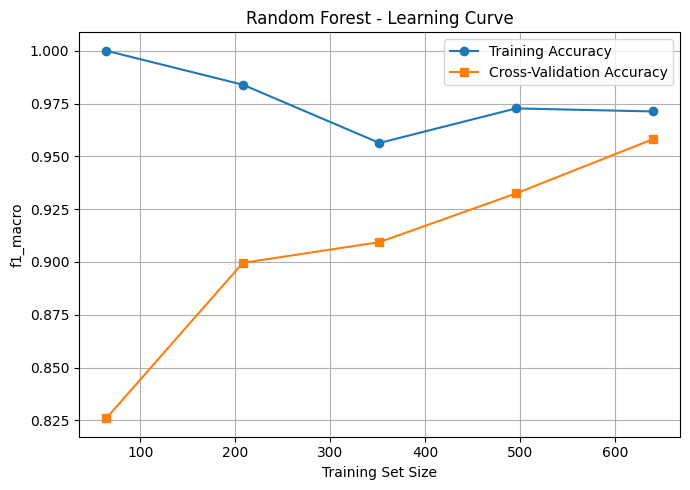

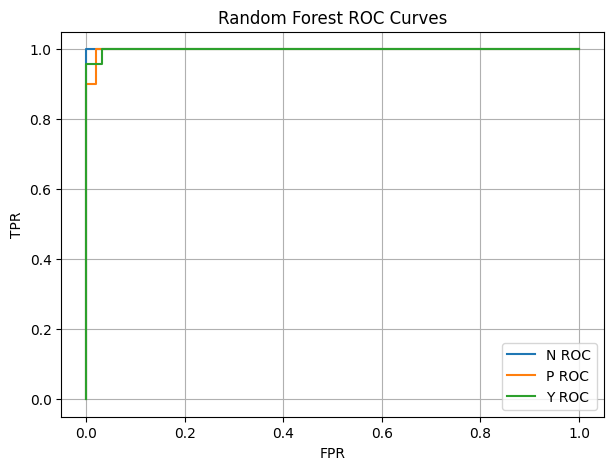

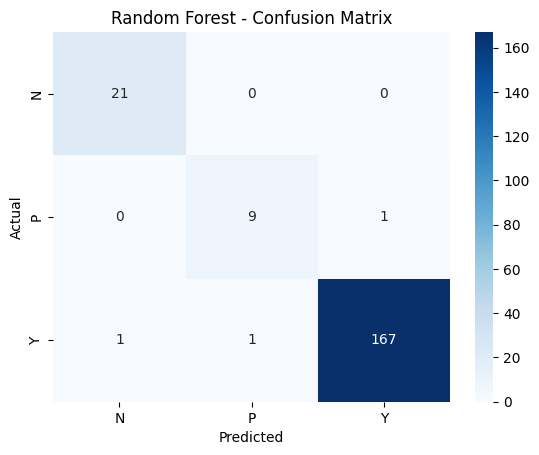


=== Training Logistic Regression ===
Logistic Regression - After Resampling Class Counts:
CLASS
0    675
1    675
2    675
Name: count, dtype: int64
Logistic Regression Coefficients:
Gender   -0.688277
AGE      -0.427321
Urea      0.173437
Cr       -0.318227
HbA1c    -8.083711
Chol     -0.594601
TG       -0.612015
HDL      -0.755449
LDL      -0.411260
VLDL     -0.291703
BMI      -4.313970
dtype: float64

Logistic Regression - Learning Curve


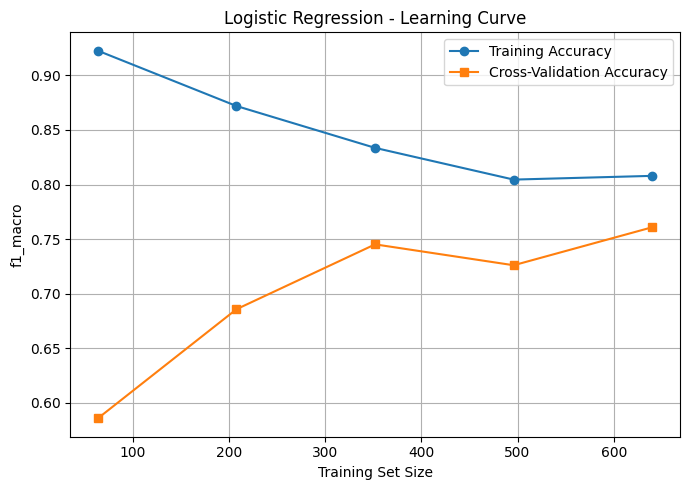

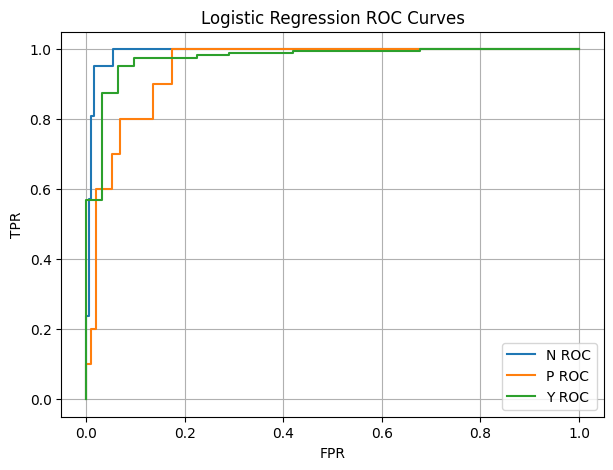

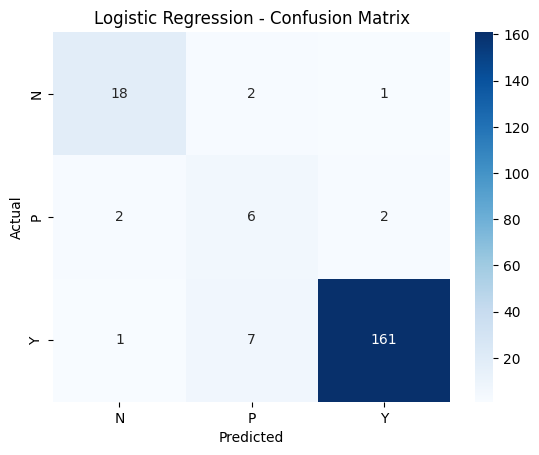


=== Training K-Nearest Neighbors ===
K-Nearest Neighbors - After Resampling Class Counts:
CLASS
0    675
1    675
2    675
Name: count, dtype: int64

K-Nearest Neighbors - Learning Curve


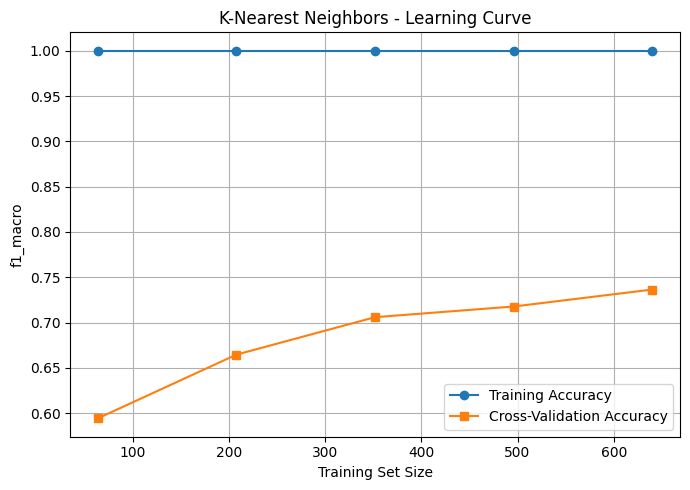

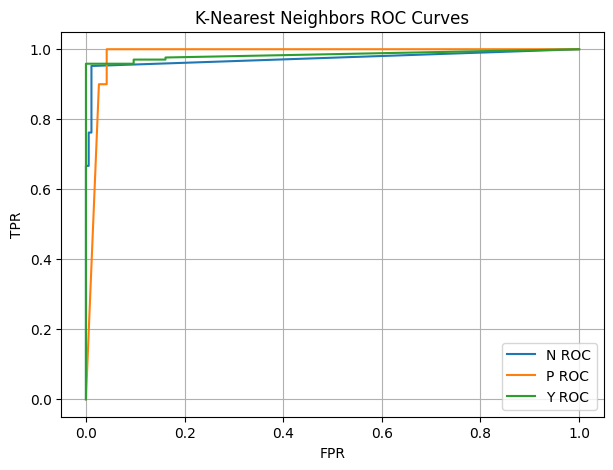

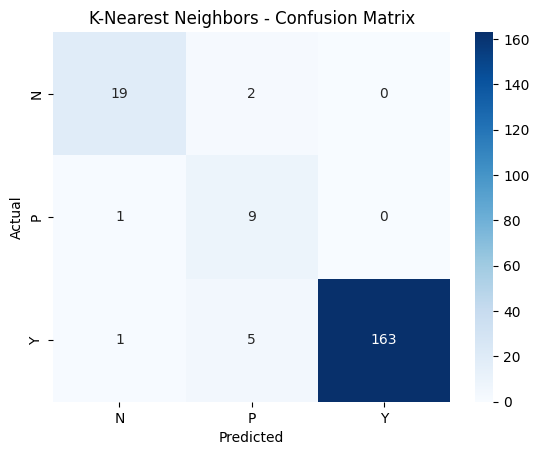


=== Training Support Vector Machine ===
Support Vector Machine - After Resampling Class Counts:
CLASS
0    675
1    675
2    675
Name: count, dtype: int64

Support Vector Machine - Learning Curve


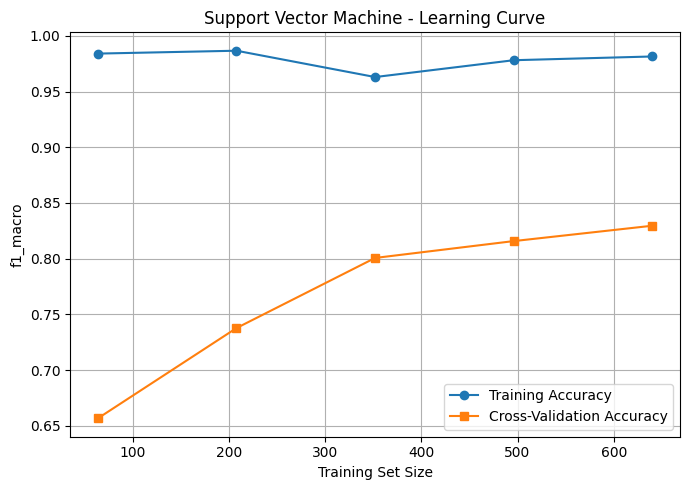

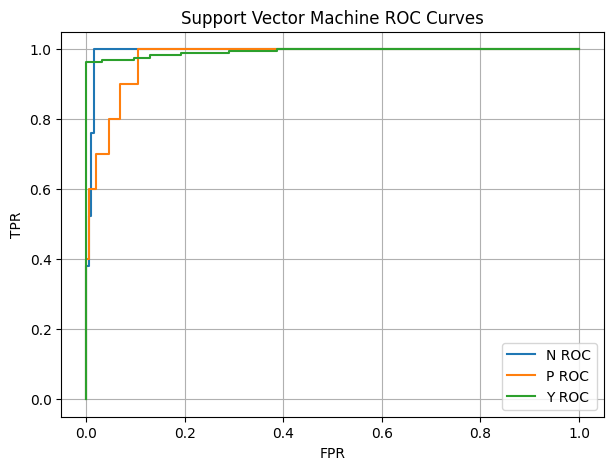

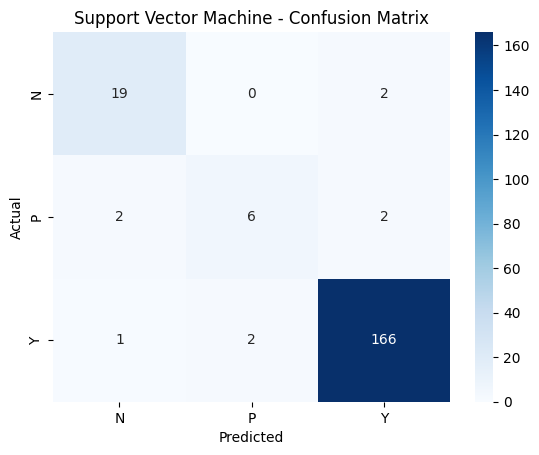

In [16]:
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, config in models.items():
    print(f"\n=== Training {name} ===")

    # Resample only to show class counts
    temp_pipeline = make_pipeline(
        StandardScaler(),
        SafeSMOTENC(
            categorical_features=[cat_index],
            random_state=42,
            sampling_strategy='auto'
        )
    )
    X_resampled, y_resampled = temp_pipeline.fit_resample(X_train, y_train)

    print(f"{name} - After Resampling Class Counts:")
    print(pd.Series(y_resampled).value_counts().sort_index())

    pipeline = make_pipeline(
        StandardScaler(),
        SafeSMOTENC(
            categorical_features=[cat_index],
            random_state=42,
            sampling_strategy='auto'
        ),
        config["model"]
    )

    search = GridSearchCV(
        pipeline,
        config['params'],
        scoring='f1_macro',
        cv=cv,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    model_step = config["model"].__class__.__name__.lower()

    # Save model
    joblib.dump(best_model, f'{name.replace(" ", "_")}_model.pkl')

    # Feature Importance / Coefficients
    model = best_model.named_steps[model_step]
    if hasattr(model, 'feature_importances_'):
        print(f"{name} Feature Importances:")
        print(pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False))
    elif hasattr(model, 'coef_'):
        print(f"{name} Coefficients:")
        print(pd.Series(model.coef_[0], index=X.columns))

    # Learning Curve
    print(f"\n{name} - Learning Curve")
    train_sizes, train_scores, val_scores = learning_curve(
        best_model, X_train, y_train, cv=cv, scoring='f1_macro',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    train_scores_mean = train_scores.mean(axis=1)
    val_scores_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(7, 5))
    plt.plot(train_sizes, train_scores_mean, label="Training Accuracy", marker='o')
    plt.plot(train_sizes, val_scores_mean, label="Cross-Validation Accuracy", marker='s')
    plt.title(f"{name} - Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("f1_macro")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Predict
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)

    # ROC Curve
    y_bin = label_binarize(y_test, classes=np.unique(y))
    y_prob_bin = best_model.predict_proba(X_test)
    plt.figure(figsize=(7, 5))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob_bin[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} ROC')
    plt.title(f'{name} ROC Curves')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.grid()
    plt.show()

    # Store Results
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'auc_macro': roc_auc_score(y_bin, y_prob_bin, average='macro', multi_class='ovr'),
        'report': classification_report(y_test, y_pred, target_names=class_names),
        'matrix': confusion_matrix(y_test, y_pred),
        'best_params': search.best_params_
    }

    # Confusion matrix
    sns.heatmap(results[name]['matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


=== Model Comparison Summary ===
                       accuracy  f1_macro auc_macro
Random Forest             0.985  0.955947  0.998853
Logistic Regression       0.925  0.768037  0.970356
K-Nearest Neighbors       0.955  0.859666  0.980412
Support Vector Machine    0.955  0.843246  0.986869


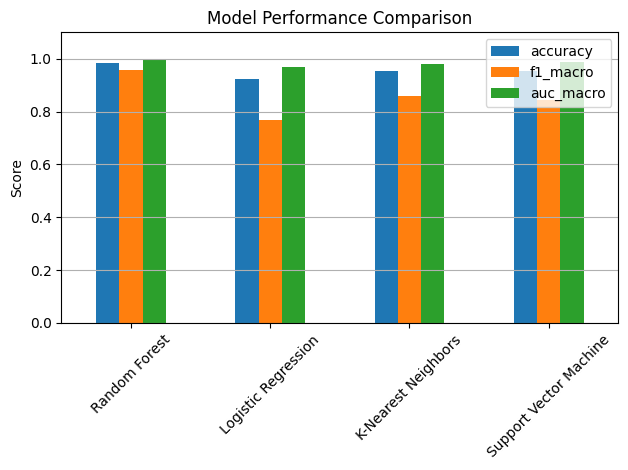

In [17]:
# Summary Table
summary_df = pd.DataFrame(results).T[['accuracy', 'f1_macro', 'auc_macro']]
print("\n=== Model Comparison Summary ===")
print(summary_df)

# Final Model Comparison Bar Plot
summary_df.plot.bar(rot=45)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()